<a href="https://colab.research.google.com/github/shcho11/00.Projects_KoreaUniv_2023-1/blob/main/202306_DM_EchoProCrawling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 에코프로 종목토론실 댓글 일중 분간격 크롤링 및 감성분석 기반 LSTM 모델링
- 날짜별 10개(또는 20개)씩 문장 단위로 넣어서 감성분석
- 이를 데이터프레임으로 만들기 (10rows * num of sentiments)
- 날짜별 감성점수 합계
- 레이블 수집: 주가
- LSTM 모델링
- SHAP 분석

In [ ]:
# 일중 분간격 데이터

import requests
from bs4 import BeautifulSoup
import re
import time
import pandas as pd
from datetime import datetime, timedelta


def get_comments_timely(stock_code, max_comments_per_min):  # max_comments_per_day 추가
    url = "https://finance.naver.com/item/board.nhn?code=" + stock_code + "&page=1"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}

    html = requests.get(url, headers=headers).text
    soup = BeautifulSoup(html, "html.parser")

    comments = []
    comment_date_list = []
    comments_per_min_list = []

    current_date = None  # 현재 날짜를 저장할 변수 추가
    comments_per_min = 0  # 현재 날짜의 댓글 수를 저장할 변수 추가

    for i in range(0, 300, 1):  # 댓글 페이지당 20개 댓글 있음.
      url = "https://finance.naver.com/item/board.nhn?code=" + stock_code + "&page=" + str(i + 1)
      html = requests.get(url, headers=headers).text
      soup = BeautifulSoup(html, "html.parser")
      comment_divs = soup.find_all("td", class_="title")  # 댓글이 들어있는 div 태그 찾기
      date_str = [span for span in soup.find_all("span", class_="tah p10 gray03") if ":" in span.get_text()]  # 댓글이 작성된 날짜,시간 가져오기

      for i, comment_div in enumerate(comment_divs) :
        comment = re.sub(r'\s+', ' ', comment_div.text)  # 댓글 내용에서 공백을 모두 제거
        comment_date = date_str[i].text.strip()[:16]
        comment_date = datetime.strptime(comment_date, "%Y.%m.%d %H:%M")  # 댓글이 작성된 날짜를 datetime 객체로 변환

        if comments_per_min < max_comments_per_min:
          if current_date is None:  # 첫 번째 댓글일 경우
            current_date = comment_date
            comments_per_min = 1
            comments.append(comment)
            comment_date_list.append(current_date)
            comments_per_min_list.append(comments_per_min)

          elif current_date == comment_date:  # 이전 댓글과 동일한 시간
            comments_per_min += 1
            comments.append(comment)
            comment_date_list.append(current_date)
            comments_per_min_list.append(comments_per_min)

          elif current_date < comment_date: # 이전 댓글보다 미래 시간 (대댓글)
            continue

          else : # 이전 댓글보다 과거 시간
            current_date = comment_date
            comments_per_min = 1
            comments.append(comment)
            comment_date_list.append(current_date)
            comments_per_min_list.append(comments_per_min)


        else : # comments_per_day가 max 도달한 경우
          if current_date == comment_date:  # 그럼에도 이전 댓글과 동일한 날짜인 경우
            continue

          elif current_date < comment_date: # 이전 댓글보다 미래 시간 (대댓글)
            continue

          else : # 이전 댓글보다 과거 시간
            current_date = comment_date
            comments_per_min = 0

      time.sleep(1)  # 1초 간격으로 크롤링

    df = pd.DataFrame({"date":comment_date_list, "order":comments_per_min_list, "comment":comments})

    return df


In [ ]:
pd.set_option('display.max_rows', 15)

if __name__ == "__main__":
    stock_code = "086520" # 에코프로 종목 코드
    max_comments_per_min = 5  # 1분당 가져올 최대 댓글 수
    df_result = get_comments_timely(stock_code, max_comments_per_min)

df_result

,date,order,comment
0,2023-06-14 05:01:00,1,매출.영업이익. 잘나가네요.
1,2023-06-14 04:54:00,1,칙~~칙~~~치익~~
2,2023-06-14 04:47:00,1,주가가 오르다보니
3,2023-06-14 04:43:00,1,밧데리아저씨 왈!!!!!
4,2023-06-14 04:38:00,1,오늘은 진짜 전고뚫는날이다 테슬라 또 폭... [1]
...,...,...,...
1523,2023-06-13 12:11:00,1,쳐박으라고 폭포수 ㅋ [6]
1524,2023-06-13 12:11:00,2,■쓰리봉에 기관외인 매물 쏟아지네■고점인... [2]
1525,2023-06-13 12:11:00,3,김현수 한병화 이래도 너희가 옳으냐? [1]
1526,2023-06-13 12:11:00,4,오우 공매 사롸있네~~^^


In [ ]:
df_result1 = df_result.copy()
df_result1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1528 entries, 0 to 1527
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     1528 non-null   datetime64[ns]
 1   order    1528 non-null   int64         
 2   comment  1528 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 35.9+ KB


In [ ]:
dates = df_result1.date.tolist()
tostr = []

for date in dates :
  date = date.strftime("%Y-%m-%d %H:%M")
  tostr.append(date)

df_result1['date'] = tostr
df_result1

,date,order,comment
0,2023-06-14 05:01,1,매출.영업이익. 잘나가네요.
1,2023-06-14 04:54,1,칙~~칙~~~치익~~
2,2023-06-14 04:47,1,주가가 오르다보니
3,2023-06-14 04:43,1,밧데리아저씨 왈!!!!!
4,2023-06-14 04:38,1,오늘은 진짜 전고뚫는날이다 테슬라 또 폭... [1]
...,...,...,...
1523,2023-06-13 12:11,1,쳐박으라고 폭포수 ㅋ [6]
1524,2023-06-13 12:11,2,■쓰리봉에 기관외인 매물 쏟아지네■고점인... [2]
1525,2023-06-13 12:11,3,김현수 한병화 이래도 너희가 옳으냐? [1]
1526,2023-06-13 12:11,4,오우 공매 사롸있네~~^^


In [ ]:
df_result1[['Date', 'Time']] = df_result1['date'].str.split(' ', 1, expand=True)
df_result1 = df_result1[['Date','Time','comment']].sort_values(by='Time', ascending=True).reset_index(drop=True)
df_result1

<ipython-input-8-9da096537691>:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_result1[['Date', 'Time']] = df_result1['date'].str.split(' ', 1, expand=True)


,Date,Time,comment
0,2023-06-14,00:01,지난 글중에도 [2]
1,2023-06-14,00:02,@아무리 봐도 이번주 90인데 [3]
2,2023-06-14,00:05,■ 테슬라 13일째 급등 중! 쑤와리 질... [3]
3,2023-06-14,00:06,지난 쌍봉때 다 못팔았나ㅋ [5]
4,2023-06-14,00:06,음봉요정입니다 [2]
...,...,...,...
1523,2023-06-13,23:52,애풀 휴대폰하나 만드는데 시총3700조 [1]
1524,2023-06-13,23:54,낼 900찍고 꼴아 밖을듯하다. [5]
1525,2023-06-13,23:54,안티들 글을 써야겠고
1526,2023-06-13,23:55,오늘 박순혁님 방송 정리 [4]


In [ ]:
df_result1 = df_result1.loc[((df_result1['Date'] == '2023-06-13') &
                             (df_result1['Time'] <= '15:30') &
                              (df_result1['Time'] >= '12:30'))]
df_result1

,Date,Time,comment
184,2023-06-13,12:30,시장광기에 탑승
185,2023-06-13,12:30,공매 정신못차리것네ㅋㅋ
186,2023-06-13,12:30,평단 80에서 물타 73만
187,2023-06-13,12:30,또코프로 후덜?
188,2023-06-13,12:30,롱은 숏의 벽을 뚫는다.
...,...,...,...
823,2023-06-13,15:28,세력애들이 돈10조로 100조 만든다.
824,2023-06-13,15:28,숏충이들이 공포를 느끼는 구간
825,2023-06-13,15:28,우리보고 팔으란다 니꺼나 다파세요
826,2023-06-13,15:29,"■■■■■■ 찢 벌레들 ,,,, ... [1]"


In [ ]:
df_result1.reset_index(drop=True, inplace=True)

In [ ]:
df_result1.head()

,Date,Time,comment
0,2023-06-13,12:30,시장광기에 탑승
1,2023-06-13,12:30,공매 정신못차리것네ㅋㅋ
2,2023-06-13,12:30,평단 80에서 물타 73만
3,2023-06-13,12:30,또코프로 후덜?
4,2023-06-13,12:30,롱은 숏의 벽을 뚫는다.


In [ ]:
df_timecount = pd.DataFrame(df_result1['Time'].value_counts())
print(df_timecount['Time'].value_counts())
print(df_timecount['Time'].value_counts().sum())

5    79
3    28
2    28
4    23
1    17
Name: Time, dtype: int64
175


In [ ]:
df_result1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     644 non-null    object
 1   Time     644 non-null    object
 2   comment  644 non-null    object
dtypes: object(3)
memory usage: 15.2+ KB


In [ ]:
unitime_list = df_result1.Time.unique().tolist()

for i in range(len(unitime_list)) :
  globals()['comments_{}{}'.format(unitime_list[i][0:2], unitime_list[i][-2:])] = ''
  unitime = unitime_list[i]

  for j in range(len(df_result1)) :
    if df_result1['Time'][j] == unitime :
      globals()['comments_{}{}'.format(unitime_list[i][0:2], unitime_list[i][-2:])] += df_result1['comment'][j] + ' '

    elif df_result1['Time'][j] < unitime :
      continue

    elif df_result1['Time'][j] > unitime :
      break

    else :
      pass


In [ ]:
print(comments_1230)
print(comments_1530)

 시장광기에 탑승   공매 정신못차리것네ㅋㅋ   평단 80에서 물타 73만   또코프로 후덜?   롱은 숏의 벽을 뚫는다.  
 공매  


In [ ]:
import re

def remove_special_characters_and_numbers(text):
    pattern = r'[^a-zA-Z가-힣\s]'  # 알파벳, 한글, 공백을 제외한 모든 문자
    result = re.sub(pattern, '', text)  # 특수문자와 숫자 제거
    return result

In [ ]:
for i in range(len(unitime_list)) :
  globals()['comments_{}{}'.format(unitime_list[i][0:2], unitime_list[i][-2:])] = remove_special_characters_and_numbers(globals()['comments_{}{}'.format(unitime_list[i][0:2], unitime_list[i][-2:])])

In [ ]:
print(comments_1230)
print(comments_1530)

 시장광기에 탑승   공매 정신못차리것네   평단 에서 물타 만   또코프로 후덜   롱은 숏의 벽을 뚫는다  
 공매  


In [ ]:
!pip install konlpy
from konlpy.tag import Okt
from wordcloud import WordCloud
from PIL import Image
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 코랩 한글
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#rm ~/.cache/matplotlib -rf

In [ ]:
df_wc1 = df_result1.loc[df_result1['Time'] < '13:30']
df_wc2 = df_result1.loc[((df_result1['Time'] < '14:30') & (df_result1['Time'] >= '13:30'))]
df_wc3 = df_result1.loc[((df_result1['Time'] < '15:30') & (df_result1['Time'] >= '14:30'))]

list_wc1 = df_wc1.comment.tolist()
list_wc2 = df_wc2.comment.tolist()
list_wc3 = df_wc3.comment.tolist()

In [ ]:
okt = Okt()

def oktnouns(list) :
  text1 = ''
  for sentence in list :
    for noun in okt.nouns(sentence) :
      if noun in ['데','이','그','것','건','전','사','배','등','중','못','수','저','더','에코','프로','에코프로'] :
        pass
      else :
        text1 += noun + ' '

  return text1

In [ ]:
text_wc1 = oktnouns(list_wc1)
text_wc2 = oktnouns(list_wc2)
text_wc3 = oktnouns(list_wc3)


In [ ]:
from PIL import Image
mask_image = np.array(Image.open('drive/MyDrive/rocket.jpg'))

def clouds(text, filename) :
  wc = WordCloud(background_color = 'black',
                 font_path = 'drive/MyDrive/HMFMMUEX.TTC',
                 max_words = 100,
                 max_font_size = 100,
                 min_font_size = 10,
                 mask = mask_image,
                 colormap = 'Set3').generate(text) # colormap : https://www.kaggle.com/code/niteshhalai/wordcloud-colormap

  wc.to_file(f'{filename}.png')

In [ ]:
clouds(text_wc1, 'wc1')

In [ ]:
clouds(text_wc2, 'wc2')

In [ ]:
clouds(text_wc3, 'wc3')

In [ ]:
!ls

drive  sample_data  wc1.png  wc2.png  wc3.png


In [ ]:
print(mask_image)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


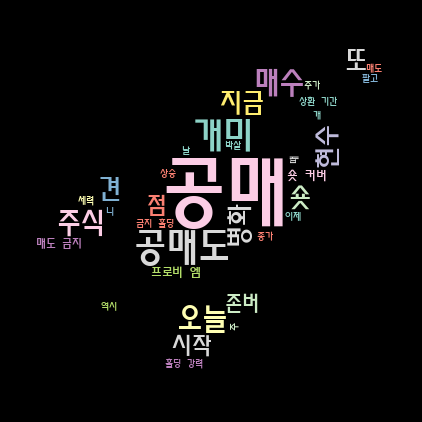

In [ ]:
from IPython.display import Image
Image('wc1.png')

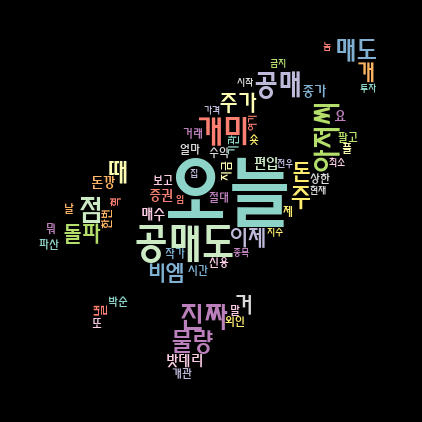

In [ ]:
Image('wc2.png')

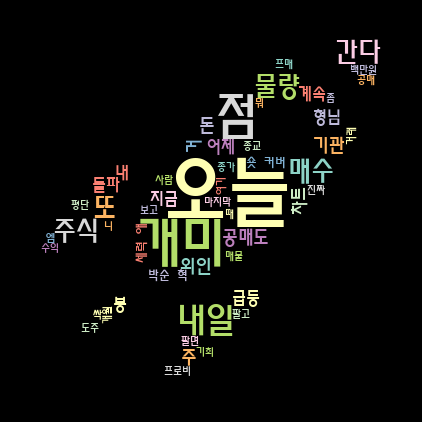

In [ ]:
Image('wc3.png')

# 감성분석기

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset

dataset = load_dataset("searle-j/kote")
print(dataset)

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'labels'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['ID', 'text', 'labels'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['ID', 'text', 'labels'],
        num_rows: 5000
    })
})


In [ ]:
comments_list = []

for i in range(len(unitime_list)) :
  comments_list.append(globals()['comments_{}{}'.format(unitime_list[i][0:2], unitime_list[i][-2:])])

comments_list

[' 시장광기에 탑승   공매 정신못차리것네   평단 에서 물타 만   또코프로 후덜   롱은 숏의 벽을 뚫는다  ',
 ' 대장답다   혀현현수씨 벼병병화   에코프로 상승폭발   만원설 달러설 현수 어딨냐   Vi 대기중  ',
 ' 개미주주여러분 만세    다음은 vi    다음은 vi   오토케 오또켕공매들 외마디   만 천주  ',
 ' 야이 OOO아 정신들 좀 차려라    현수 병화 믿고 숏첬는데   코레아 대표종목    에코프로 동생 에코프로비엠도   내일부턴 숏커버 제대로 나오겠네요   ',
 ' 오늘도 추매했다공매 파산   렴이 또 대주물량 안주네    전 천만원 주전 투자했지만   멈추어서 매집구간 보인다   종가   ',
 ' 전고점   에코프로   에코 문열자마자 전고점곧찍으니 공매도   만원간다 주워담아라 제발    에코프로 공매도 조초과대차물량   ',
 ' 대동단결 공매도척결    만 터치한번 한게 의미가 큼    에코프로는    안녕하세요 평단원 사람 입니다     뚫는다고 총알 다 씀   ',
 ' 영업일동안 만원이 상승역시 대박   기업이 너무 좋으니깐 공매도도 어쩔수없구   오늘도 개투들 파네 햐    월 만원 가는 이유    바카라 같은 주식이네  ',
 ' 현시점부터 하락시작    에코프로   층이상에서만 끝나도  공매들 염라   만   공견들  ',
 ' 장독대다 년 이면 천하의 진간장 된다    이러다    들리나요   백만이상갈 주식을    에코프로에 숏 치는건  ',
 ' 전 에코프로 와 에코프로비엠을    오늘 만원 터치한다   주식시작하고 최고수익중이다   개인들 만주 매도 한단다   한강 오염 경보   ',
 ' 글쓰니깐 숏친애들 바로 비공박네    개관공매츙드른 니들이 좋다고한 반도체 로   신한 sol 전지 소부장 etf 심가한    두시되면 까지는 갈듯   팔아야하나요 더올라가겠죠   ',
 ' 까진 가지말드라고   펄어비스던가 공매도파산한 경우가 한국에    지가 보기에는   착각일 수도   목표가가 만

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

model_name = "searle-j/kote_for_easygoing_people"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

pipe = TextClassificationPipeline(
        model=model,
        tokenizer=tokenizer,
        device=0, # gpu number, -1 if cpu used
        return_all_scores=True,
        function_to_apply='sigmoid'
    )

for i in range(len(comments_list)) :
  globals()['df_comment{}'.format(i+1)] = pd.DataFrame(columns=['label','score'])
  for output in pipe(comments_list[i])[0]:
    if output["score"]>0.4:
      df_output = pd.DataFrame(output, index=[0])
      globals()['df_comment{}'.format(i+1)] = pd.concat([globals()['df_comment{}'.format(i+1)], df_output])

In [ ]:
for i in range(len(comments_list)) :
  globals()['df_comment{}'.format(i+1)] = globals()['df_comment{}'.format(i+1)].set_index('label', drop=True)
  globals()['df_comment{}'.format(i+1)] = globals()['df_comment{}'.format(i+1)].transpose()
#display(globals()['df_comment{}'.format(i+1)])
display(df_comment1)


label,기대감,안타까움/실망,신기함/관심,한심함,짜증,어이없음,깨달음,당황/난처,놀람
score,0.504186,0.516742,0.491424,0.445011,0.436466,0.646818,0.464634,0.541844,0.5422


In [ ]:
concat_df = []

for i in range(len(comments_list)) :
  concat_df.append(globals()['df_comment{}'.format(i+1)])

concatenated_df = pd.concat(concat_df)
concatenated_df

label,기대감,안타까움/실망,신기함/관심,한심함,짜증,어이없음,깨달음,당황/난처,놀람,환영/호의,...,뿌듯함,편안/쾌적,아껴주는,존경,부끄러움,패배/자기혐오,죄책감,흐뭇함(귀여움/예쁨),서러움,재미없음
score,0.504186,0.516742,0.491424,0.445011,0.436466,0.646818,0.464634,0.541844,0.5422,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,0.921658,NaN,0.704348,NaN,NaN,NaN,NaN,NaN,NaN,0.47505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,0.780854,NaN,NaN,0.464505,0.539759,0.470011,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,0.427408,0.803598,NaN,NaN,0.701311,0.566945,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,0.416893,0.636578,NaN,NaN,0.639478,0.415339,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
score,0.898151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,NaN,0.405806,NaN,0.514370,0.499159,0.729369,NaN,0.595746,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,NaN,0.610504,NaN,0.883122,0.950924,0.842373,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,NaN,NaN,NaN,0.739889,0.886099,0.532885,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
concatenated_df.columns

Index(['기대감', '안타까움/실망', '신기함/관심', '한심함', '짜증', '어이없음', '깨달음', '당황/난처', '놀람',
       '환영/호의', '불안/걱정', '불평/불만', '지긋지긋', '화남/분노', '우쭐댐/무시함', '비장함', '즐거움/신남',
       '의심/불신', '절망', '힘듦/지침', '불쌍함/연민', '없음', '감동/감탄', '역겨움/징그러움', '증오/혐오',
       '경악', '부담/안_내킴', '귀찮음', '안심/신뢰', '행복', '기쁨', '슬픔', '공포/무서움', '고마움',
       '뿌듯함', '편안/쾌적', '아껴주는', '존경', '부끄러움', '패배/자기혐오', '죄책감', '흐뭇함(귀여움/예쁨)',
       '서러움', '재미없음'],
      dtype='object', name='label')

In [ ]:
concatenated_df['Time'] = unitime_list
concatenated_df.reset_index(drop=True, inplace=True)

col_list = concatenated_df.columns.tolist()
new_col_list = col_list[-1:] + col_list[:-1]

concatenated_df = concatenated_df[new_col_list]
concatenated_df

label,Time,기대감,안타까움/실망,신기함/관심,한심함,짜증,어이없음,깨달음,당황/난처,놀람,...,뿌듯함,편안/쾌적,아껴주는,존경,부끄러움,패배/자기혐오,죄책감,흐뭇함(귀여움/예쁨),서러움,재미없음
0,12:30,0.504186,0.516742,0.491424,0.445011,0.436466,0.646818,0.464634,0.541844,0.5422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12:31,0.921658,NaN,0.704348,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12:32,0.780854,NaN,NaN,0.464505,0.539759,0.470011,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12:33,0.427408,0.803598,NaN,NaN,0.701311,0.566945,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12:34,0.416893,0.636578,NaN,NaN,0.639478,0.415339,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,15:25,0.898151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171,15:27,NaN,0.405806,NaN,0.514370,0.499159,0.729369,NaN,0.595746,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172,15:28,NaN,0.610504,NaN,0.883122,0.950924,0.842373,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,15:29,NaN,NaN,NaN,0.739889,0.886099,0.532885,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
price = pd.read_excel('drive/MyDrive/echopro_price0613.xlsx')
price.head()

,체결시각,체결가,전일비,매도,매수,거래량,변동량
0,12:30:00,750000,"상승 58,000",750000,749000,988341,4709
1,12:31:00,748000,"상승 56,000",748000,747000,1020496,32155
2,12:32:00,746000,"상승 54,000",747000,746000,1027718,7222
3,12:33:00,747000,"상승 55,000",747000,746000,1029592,1874
4,12:34:00,744000,"상승 52,000",745000,744000,1035607,6015


In [ ]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   체결시각    171 non-null    object
 1   체결가     171 non-null    int64 
 2   전일비     171 non-null    object
 3   매도      171 non-null    int64 
 4   매수      171 non-null    int64 
 5   거래량     171 non-null    int64 
 6   변동량     171 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 9.5+ KB


In [ ]:
dates = price.체결시각.tolist()
tostr = []

for date in dates :
  date = date.strftime("%H:%M")
  tostr.append(date)

price['체결시각'] = tostr
price

,체결시각,체결가,전일비,매도,매수,거래량,변동량
0,12:30,750000,"상승 58,000",750000,749000,988341,4709
1,12:31,748000,"상승 56,000",748000,747000,1020496,32155
2,12:32,746000,"상승 54,000",747000,746000,1027718,7222
3,12:33,747000,"상승 55,000",747000,746000,1029592,1874
4,12:34,744000,"상승 52,000",745000,744000,1035607,6015
...,...,...,...,...,...,...,...
166,15:16,744000,"상승 52,000",745000,744000,1390202,2417
167,15:17,747000,"상승 55,000",747000,746000,1400500,10298
168,15:18,748000,"상승 56,000",749000,748000,1405124,4624
169,15:19,748000,"상승 56,000",749000,748000,1408862,3738


In [ ]:
price = price[['체결시각','체결가']]

df_fin = pd.merge(price, concatenated_df, left_on = '체결시각', right_on='Time', how='inner')
df_fin

,체결시각,체결가,Time,기대감,안타까움/실망,신기함/관심,한심함,짜증,어이없음,깨달음,...,뿌듯함,편안/쾌적,아껴주는,존경,부끄러움,패배/자기혐오,죄책감,흐뭇함(귀여움/예쁨),서러움,재미없음
0,12:30,750000,12:30,0.504186,0.516742,0.491424,0.445011,0.436466,0.646818,0.464634,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12:31,748000,12:31,0.921658,NaN,0.704348,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12:32,746000,12:32,0.780854,NaN,NaN,0.464505,0.539759,0.470011,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12:33,747000,12:33,0.427408,0.803598,NaN,NaN,0.701311,0.566945,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12:34,744000,12:34,0.416893,0.636578,NaN,NaN,0.639478,0.415339,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,15:16,744000,15:16,NaN,NaN,NaN,0.538712,0.663346,0.581780,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,15:17,747000,15:17,0.826023,NaN,NaN,NaN,NaN,NaN,0.693885,...,0.443665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,15:18,748000,15:18,0.865245,NaN,0.522766,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,15:19,748000,15:19,NaN,0.843124,NaN,NaN,NaN,NaN,0.408252,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 0 to 165
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   체결시각         166 non-null    object 
 1   체결가          166 non-null    int64  
 2   Time         166 non-null    object 
 3   기대감          99 non-null     float64
 4   안타까움/실망      89 non-null     float64
 5   신기함/관심       37 non-null     float64
 6   한심함          69 non-null     float64
 7   짜증           88 non-null     float64
 8   어이없음         83 non-null     float64
 9   깨달음          31 non-null     float64
 10  당황/난처        39 non-null     float64
 11  놀람           19 non-null     float64
 12  환영/호의        31 non-null     float64
 13  불안/걱정        59 non-null     float64
 14  불평/불만        90 non-null     float64
 15  지긋지긋         48 non-null     float64
 16  화남/분노        78 non-null     float64
 17  우쭐댐/무시함      40 non-null     float64
 18  비장함          58 non-null     float64
 19  즐거움/신남  

In [ ]:
df_nulls = pd.DataFrame(df_fin.isnull().sum(), columns=['null']).sort_values(by='null', ascending=True)
df_nulls

,null
체결시각,0
체결가,0
Time,0
기대감,67
불평/불만,76
...,...
부끄러움,164
패배/자기혐오,164
죄책감,164
서러움,164


In [ ]:
df_nulls.index.tolist()[0:23]

['체결시각',
 '체결가',
 'Time',
 '기대감',
 '불평/불만',
 '안타까움/실망',
 '짜증',
 '의심/불신',
 '어이없음',
 '화남/분노',
 '한심함',
 '불안/걱정',
 '비장함',
 '없음',
 '지긋지긋',
 '우쭐댐/무시함',
 '즐거움/신남',
 '당황/난처',
 '증오/혐오',
 '신기함/관심',
 '깨달음',
 '환영/호의',
 '감동/감탄']

In [ ]:
df_fin = df_fin[df_nulls.index.tolist()[0:23]].drop(columns=['Time'])
df_fin

,체결시각,체결가,기대감,불평/불만,안타까움/실망,짜증,의심/불신,어이없음,화남/분노,한심함,...,없음,지긋지긋,우쭐댐/무시함,즐거움/신남,당황/난처,증오/혐오,신기함/관심,깨달음,환영/호의,감동/감탄
0,12:30,750000,0.504186,NaN,0.516742,0.436466,NaN,0.646818,NaN,0.445011,...,NaN,NaN,NaN,NaN,0.541844,NaN,0.491424,0.464634,NaN,NaN
1,12:31,748000,0.921658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.704348,NaN,0.47505,NaN
2,12:32,746000,0.780854,0.480653,NaN,0.539759,NaN,0.470011,0.526470,0.464505,...,NaN,0.415098,0.52699,0.479043,NaN,NaN,NaN,NaN,NaN,NaN
3,12:33,747000,0.427408,0.878123,0.803598,0.701311,0.667428,0.566945,0.611101,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12:34,744000,0.416893,0.677012,0.636578,0.639478,NaN,0.415339,0.491597,NaN,...,NaN,0.542859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,15:16,744000,NaN,0.413237,NaN,0.663346,0.517680,0.581780,0.822004,0.538712,...,NaN,NaN,NaN,NaN,NaN,0.805454,NaN,NaN,NaN,NaN
162,15:17,747000,0.826023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.400913,NaN,NaN,0.579414,NaN,NaN,NaN,0.693885,NaN,0.484231
163,15:18,748000,0.865245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.578325,NaN,NaN,0.790319,NaN,NaN,0.522766,NaN,NaN,NaN
164,15:19,748000,NaN,NaN,0.843124,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.676666,NaN,NaN,0.408252,NaN,NaN


In [ ]:
df_fin1 = df_fin.fillna(0)
df_fin1

,체결시각,체결가,기대감,불평/불만,안타까움/실망,짜증,의심/불신,어이없음,화남/분노,한심함,...,없음,지긋지긋,우쭐댐/무시함,즐거움/신남,당황/난처,증오/혐오,신기함/관심,깨달음,환영/호의,감동/감탄
0,12:30,750000,0.504186,0.000000,0.516742,0.436466,0.000000,0.646818,0.000000,0.445011,...,0.000000,0.000000,0.00000,0.000000,0.541844,0.000000,0.491424,0.464634,0.00000,0.000000
1,12:31,748000,0.921658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.704348,0.000000,0.47505,0.000000
2,12:32,746000,0.780854,0.480653,0.000000,0.539759,0.000000,0.470011,0.526470,0.464505,...,0.000000,0.415098,0.52699,0.479043,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,12:33,747000,0.427408,0.878123,0.803598,0.701311,0.667428,0.566945,0.611101,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
4,12:34,744000,0.416893,0.677012,0.636578,0.639478,0.000000,0.415339,0.491597,0.000000,...,0.000000,0.542859,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,15:16,744000,0.000000,0.413237,0.000000,0.663346,0.517680,0.581780,0.822004,0.538712,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.805454,0.000000,0.000000,0.00000,0.000000
162,15:17,747000,0.826023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.400913,0.000000,0.00000,0.579414,0.000000,0.000000,0.000000,0.693885,0.00000,0.484231
163,15:18,748000,0.865245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.578325,0.000000,0.00000,0.790319,0.000000,0.000000,0.522766,0.000000,0.00000,0.000000
164,15:19,748000,0.000000,0.000000,0.843124,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.676666,0.000000,0.000000,0.408252,0.00000,0.000000


In [ ]:
findf_newcols = ['Time',
                 'Price',
                 'Expectation',
                 'Complaints/Discontent',
                 'Regret/Disappointment',
                 'Irritation',
                 'Doubt/Suspicion',
                 'Absurdity',
                 'Anger/Rage',
                 'Pity',
                 'Anxiety/Worry',
                 'Ruthlessness',
                 'None',
                 'Disgust',
                 'Arrogance/Disregard',
                 'Joy/Excitement',
                 'Confusion/Bewilderment',
                 'Hatred/Disgust',
                 'Amazement/Interest',
                 'Enlightenment',
                 'Welcome/Favor',
                 'Emotion/Admiration']


oldfindf_cols = df_fin1.columns.tolist()

for i in range(len(oldfindf_cols)) :
  df_fin1.rename(columns={oldfindf_cols[i] : findf_newcols[i]}, inplace=True)

In [ ]:
df_fin1.head()

,Time,Price,Expectation,Complaints/Discontent,Regret/Disappointment,Irritation,Doubt/Suspicion,Absurdity,Anger/Rage,Pity,...,None,Disgust,Arrogance/Disregard,Joy/Excitement,Confusion/Bewilderment,Hatred/Disgust,Amazement/Interest,Enlightenment,Welcome/Favor,Emotion/Admiration
0,12:30,750000,0.504186,0.000000,0.516742,0.436466,0.000000,0.646818,0.000000,0.445011,...,0.0,0.000000,0.00000,0.000000,0.541844,0.0,0.491424,0.464634,0.00000,0.0
1,12:31,748000,0.921658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.704348,0.000000,0.47505,0.0
2,12:32,746000,0.780854,0.480653,0.000000,0.539759,0.000000,0.470011,0.526470,0.464505,...,0.0,0.415098,0.52699,0.479043,0.000000,0.0,0.000000,0.000000,0.00000,0.0
3,12:33,747000,0.427408,0.878123,0.803598,0.701311,0.667428,0.566945,0.611101,0.000000,...,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0
4,12:34,744000,0.416893,0.677012,0.636578,0.639478,0.000000,0.415339,0.491597,0.000000,...,0.0,0.542859,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0


In [ ]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
#from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
# 코랩 한글
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

Text(0.5, 1.0, 'Correlation between the Variables')

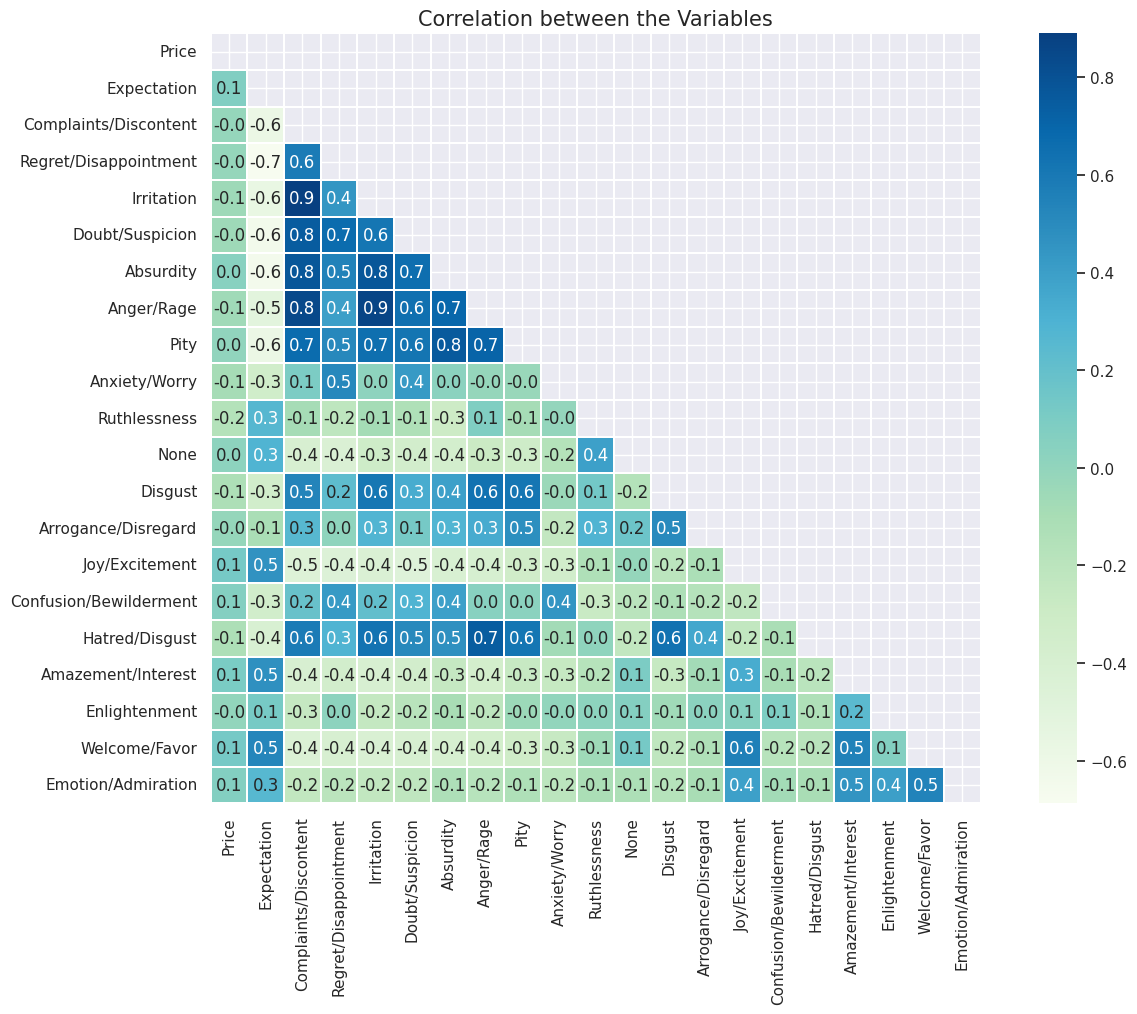

In [ ]:
import seaborn as sns
corr1 = df_fin1.corr()

sns.set(rc = {'figure.figsize':(15,10)})
mask1 = np.zeros_like(corr1, dtype=np.bool) # to plot only part of a matrix
mask1[np.triu_indices_from(mask1)] = True

sns.heatmap(corr1,
            annot = True, # write the value in each cell
            cmap = 'GnBu',
            square = True, # set the axes aspect to "equal"
            mask = mask1,
            linewidths=0.2,
            fmt='.1f')
plt.rc('font', family='NanumBarunGothic')
plt.title('Correlation between the Variables', fontsize=15)

In [ ]:
dfvf2 = df_fin1.set_index('Time')
dfvf2.head()

,Price,Expectation,Complaints/Discontent,Regret/Disappointment,Irritation,Doubt/Suspicion,Absurdity,Anger/Rage,Pity,Anxiety/Worry,...,None,Disgust,Arrogance/Disregard,Joy/Excitement,Confusion/Bewilderment,Hatred/Disgust,Amazement/Interest,Enlightenment,Welcome/Favor,Emotion/Admiration
Time,,,,,,,,,,,,,,,,,,,,,
12:30,750000,0.504186,0.000000,0.516742,0.436466,0.000000,0.646818,0.000000,0.445011,0.000000,...,0.0,0.000000,0.00000,0.000000,0.541844,0.0,0.491424,0.464634,0.00000,0.0
12:31,748000,0.921658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.412197,...,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.704348,0.000000,0.47505,0.0
12:32,746000,0.780854,0.480653,0.000000,0.539759,0.000000,0.470011,0.526470,0.464505,0.000000,...,0.0,0.415098,0.52699,0.479043,0.000000,0.0,0.000000,0.000000,0.00000,0.0
12:33,747000,0.427408,0.878123,0.803598,0.701311,0.667428,0.566945,0.611101,0.000000,0.565208,...,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0
12:34,744000,0.416893,0.677012,0.636578,0.639478,0.000000,0.415339,0.491597,0.000000,0.546256,...,0.0,0.542859,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0


In [ ]:
# Split the data into training and testing sets
train_data = dfvf2[:len(dfvf2)-49]

# LSTM모델에서 t-1 시점 변수를 가져오기 위해 아래와 같이 split
test_data = dfvf2[len(dfvf2)-50:]

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()

  # input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

  # forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

  # put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names

  # drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
train_f = series_to_supervised(train_data, 1, 1)
train_f.drop(train_f.columns[(dfvf2.shape[1]+1):], axis=1, inplace=True)

test_f = series_to_supervised(test_data, 1, 1)
test_f.drop(test_f.columns[(dfvf2.shape[1]+1):], axis=1, inplace=True)

display(train_f.head())
display(test_f.head())

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var1(t)
Time,,,,,,,,,,,,,,,,,,,,,
12:31,750000.0,0.504186,0.000000,0.516742,0.436466,0.000000,0.646818,0.000000,0.445011,0.000000,...,0.000000,0.00000,0.000000,0.541844,0.0,0.491424,0.464634,0.00000,0.0,748000
12:32,748000.0,0.921658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.412197,...,0.000000,0.00000,0.000000,0.000000,0.0,0.704348,0.000000,0.47505,0.0,746000
12:33,746000.0,0.780854,0.480653,0.000000,0.539759,0.000000,0.470011,0.526470,0.464505,0.000000,...,0.415098,0.52699,0.479043,0.000000,0.0,0.000000,0.000000,0.00000,0.0,747000
12:34,747000.0,0.427408,0.878123,0.803598,0.701311,0.667428,0.566945,0.611101,0.000000,0.565208,...,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,744000
12:35,744000.0,0.416893,0.677012,0.636578,0.639478,0.000000,0.415339,0.491597,0.000000,0.546256,...,0.542859,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,743000


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var1(t)
Time,,,,,,,,,,,,,,,,,,,,,
14:29,743000.0,0.000000,0.818554,0.693143,0.845297,0.485910,0.530499,0.629372,0.0,0.689395,...,0.561824,0.0,0.0,0.500337,0.0,0.0,0.000000,0.0,0.0,745000
14:30,745000.0,0.000000,0.637196,0.684287,0.000000,0.869232,0.500993,0.000000,0.0,0.858626,...,0.000000,0.0,0.0,0.478639,0.0,0.0,0.000000,0.0,0.0,745000
14:31,745000.0,0.724876,0.000000,0.450068,0.000000,0.000000,0.000000,0.000000,0.0,0.555393,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.411808,0.0,0.0,744000
14:32,744000.0,0.590092,0.513119,0.000000,0.544751,0.000000,0.452048,0.503867,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,745000
14:33,745000.0,0.730500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,745000


In [ ]:
print(train_f.shape, test_f.shape)

(116, 22) (49, 22)


In [ ]:
train_f = train_f.values
test_f = test_f.values

train_X, train_y = train_f[:, :-1], train_f[:, -1]
test_X, test_y = test_f[:, :-1], test_f[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(116, 1, 21) (116,) (49, 1, 21) (49,)


In [ ]:
import tensorflow as tf
import sys
import google.protobuf
import h5py
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [ ]:
# shap이 tf2 버전에서 지원되지 않는 문제 해결하기 위함.

from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
lstm_model1 = Sequential()
lstm_model1.add(LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
#lstm_model.add(Dropout(0.2))
lstm_model1.add(Dense(1))
lstm_model1.compile(optimizer='adam', loss='mse')

lstm_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               48800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 48,901
Trainable params: 48,901
Non-trainable params: 0
_________________________________________________________________


Train on 116 samples, validate on 49 samples
Epoch 1/20
116/116 [==============================] - 1s 9ms/sample - loss: 567449276274.7587 - val_loss: 528774778462.0408
Epoch 2/20
116/116 [==============================] - 0s 876us/sample - loss: 498433209591.1724 - val_loss: 461175492524.4081
Epoch 3/20
116/116 [==============================] - 0s 783us/sample - loss: 431378850074.4828 - val_loss: 395330489615.6735
Epoch 4/20
116/116 [==============================] - 0s 905us/sample - loss: 365407170136.2758 - val_loss: 328779345000.4898
Epoch 5/20
116/116 [==============================] - 0s 866us/sample - loss: 298279392220.6897 - val_loss: 261372453365.5510
Epoch 6/20
116/116 [==============================] - 0s 770us/sample - loss: 231188202601.9310 - val_loss: 195691178778.1224
Epoch 7/20
116/116 [==============================] - 0s 799us/sample - loss: 168231864814.3448 - val_loss: 137205810155.1020
Epoch 8/20
116/116 [==============================] - 0s 846us/sample - los

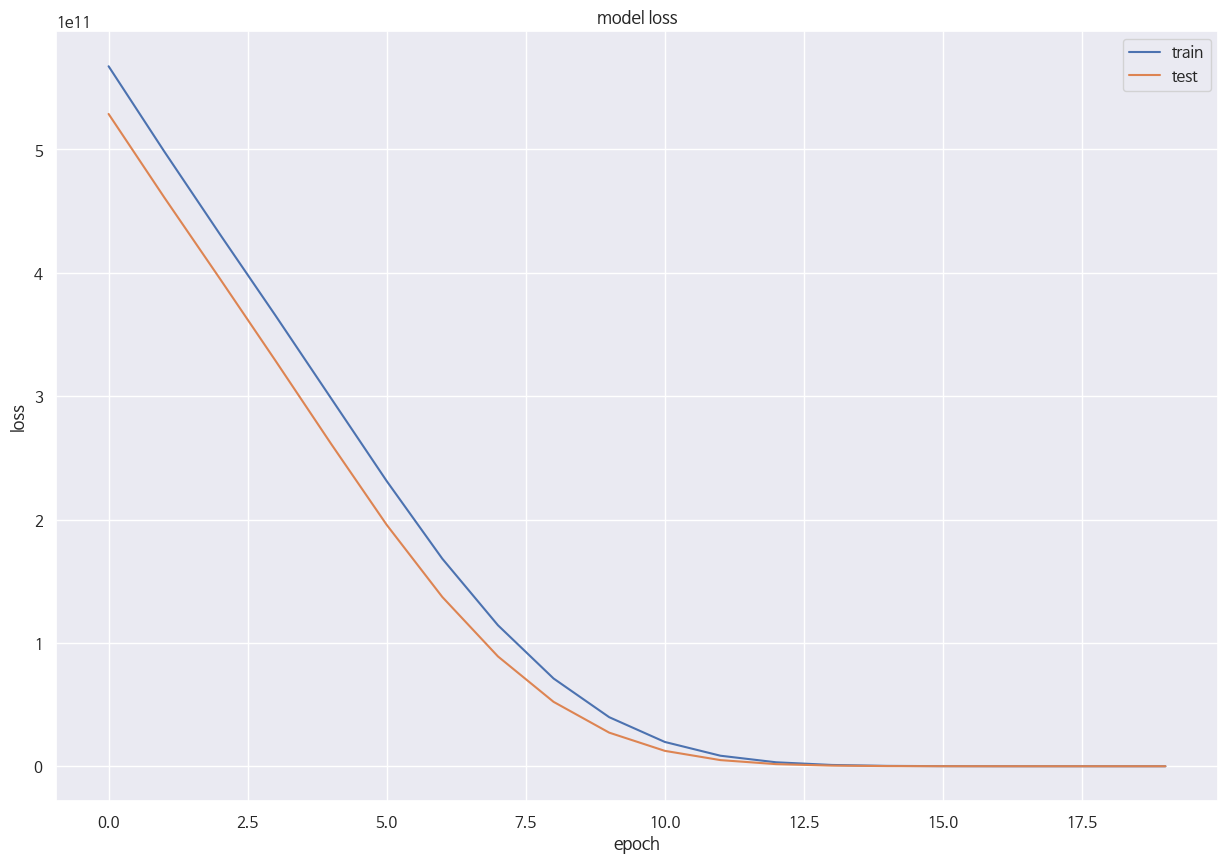

Test RMSE: 1342.787


In [ ]:
# fit network
history = lstm_model1.fit(train_X, train_y, epochs=20, batch_size=6, validation_data=(test_X, test_y), verbose=1, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = lstm_model1.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -(dfvf2.shape[1]-1):]), axis=1)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -(dfvf2.shape[1]-1):]), axis=1)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

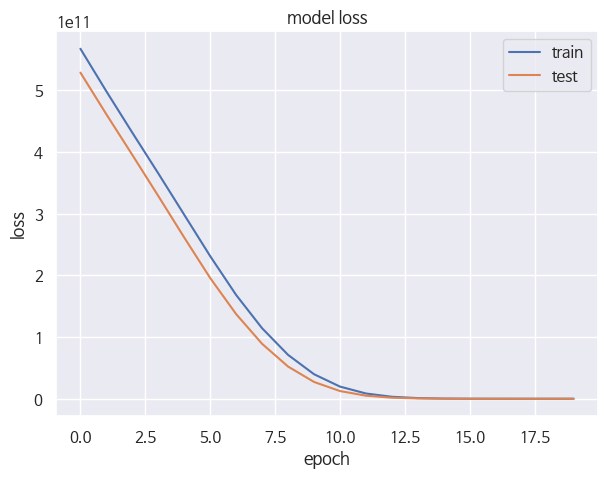

In [ ]:
plt.figure(figsize=(7,5))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
inv_yhat

array([742801.    , 744799.3125, 744798.375 , 743799.5625, 744797.4375,
       744798.75  , 744798.4375, 743801.625 , 743799.6875, 743799.625 ,
       744801.0625, 748797.5   , 747798.875 , 747796.875 , 748797.1875,
       747797.4375, 749797.4375, 747797.4375, 748797.625 , 748799.8125,
       747797.0625, 746798.5   , 745800.3125, 745799.625 , 746799.5625,
       748798.375 , 746799.0625, 746800.0625, 747799.6875, 746800.375 ,
       746797.9375, 746797.125 , 744799.25  , 742798.3125, 742805.125 ,
       741799.9375, 741799.875 , 742798.8125, 745798.125 , 744798.6875,
       744798.5   , 744797.5625, 743800.875 , 743800.125 , 744800.4375,
       743800.3125, 746798.1875, 747797.4375, 747797.5   ])

In [ ]:
eval_df = pd.DataFrame(test_data['Price'][1:])
eval_df['Prediction'] = inv_yhat.tolist()
eval_df

,Price,Prediction
Time,,
14:29,745000,742801.0000
14:30,745000,744799.3125
14:31,744000,744798.3750
14:32,745000,743799.5625
14:33,745000,744797.4375
...,...,...
15:16,744000,744800.4375
15:17,747000,743800.3125
15:18,748000,746798.1875


In [ ]:
lstm_rmse = mean_squared_error(eval_df['Price'], eval_df['Prediction'])**0.5
lstm_mse = lstm_rmse**2

print(f'LSTM MSE Error: {lstm_mse}\nLSTM RMSE Error: {lstm_rmse}')

LSTM MSE Error: 1803077.7295121176
LSTM RMSE Error: 1342.787298685878


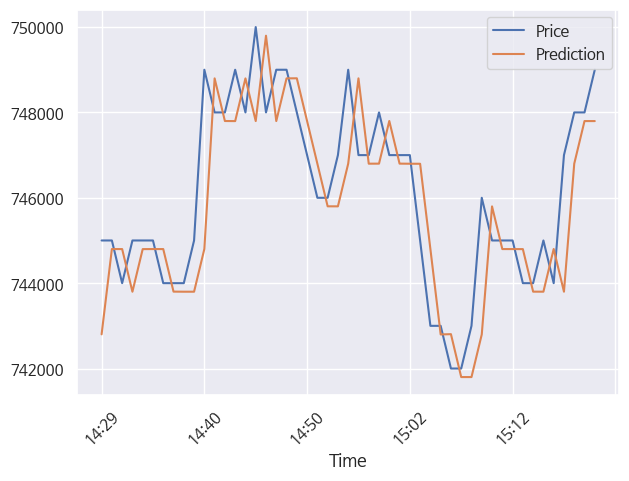

In [ ]:
eval_df.plot(figsize = (7,5), legend=True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 12.0 MB/s eta 0:00:00


In [ ]:
train_Xr = train_X.reshape((train_X.shape[0], train_X.shape[2]))
test_Xr = test_f[:, :-1]
test_Xr = test_Xr.reshape((test_Xr.shape[0], 1, test_Xr.shape[1]))
train_yr = train_y.reshape((len(train_y), 1))

print(train_Xr.shape)
print(train_X.shape)
print(train_yr.shape)

print(test_X.shape)
print(test_Xr.shape)
print(test_y.shape)

(116, 21)
(116, 1, 21)
(116, 1)
(49, 21)
(49, 1, 21)
(49, 1)


In [ ]:
import shap
DE = shap.DeepExplainer(lstm_model1, train_X) # X_train is 3d numpy.ndarray

In [ ]:
shap_values = DE.shap_values(test_Xr, check_additivity=False) # X_validate is 3d numpy.ndarray

In [ ]:
shap.initjs()

In [ ]:
shapval_0 = shap_values[0]
print(shapval_0.shape[2])

21


In [ ]:
shapval_0r = shapval_0.reshape(shapval_0.shape[0],shapval_0.shape[2])
shapval_0r.shape

(49, 21)

In [ ]:
shapval_0r = shapval_0r.tolist()

df_shapval_0r = pd.DataFrame(shapval_0r, columns=dfvf2.columns, index=eval_df.index)
df_shapval_0r.rename(columns={'price':'price(t-1)'}, inplace=True)
df_shapval_0r.head()

,Price,Expectation,Complaints/Discontent,Regret/Disappointment,Irritation,Doubt/Suspicion,Absurdity,Anger/Rage,Pity,Anxiety/Worry,...,None,Disgust,Arrogance/Disregard,Joy/Excitement,Confusion/Bewilderment,Hatred/Disgust,Amazement/Interest,Enlightenment,Welcome/Favor,Emotion/Admiration
Time,,,,,,,,,,,,,,,,,,,,,
14:29,-3792.061641,-0.324500,0.323358,0.247971,0.282244,0.096658,0.129488,0.211517,-0.191740,0.371457,...,-0.147432,0.253793,-0.109655,-0.075669,0.230250,-0.111785,-0.076637,-0.061031,-0.048197,-0.032093
14:30,-1792.610958,-0.324500,0.174748,0.241590,-0.239295,0.370004,0.107139,-0.269670,-0.191445,0.503524,...,-0.146205,-0.125786,-0.109655,-0.075669,0.216880,-0.111785,-0.076637,-0.060621,-0.048197,-0.032093
14:31,-1792.610958,0.246252,-0.342555,0.074913,-0.239474,-0.250636,-0.267753,-0.269670,-0.191740,0.266349,...,0.292128,-0.125786,-0.109454,-0.075241,-0.077777,-0.111785,-0.076478,0.203407,-0.048197,-0.032093
14:32,-2792.336300,0.140023,0.074880,-0.244208,0.096747,-0.250636,0.070743,0.115563,-0.191740,-0.166798,...,0.356224,-0.125786,-0.109655,-0.075669,-0.077777,-0.111785,-0.076637,-0.061031,-0.048197,-0.032093
14:33,-1792.610958,0.250553,-0.342555,-0.244208,-0.239474,-0.250636,-0.267753,-0.269670,-0.191740,-0.166798,...,0.365294,-0.125786,-0.109655,-0.075669,-0.077777,-0.111785,-0.076637,-0.061031,-0.048197,-0.032093


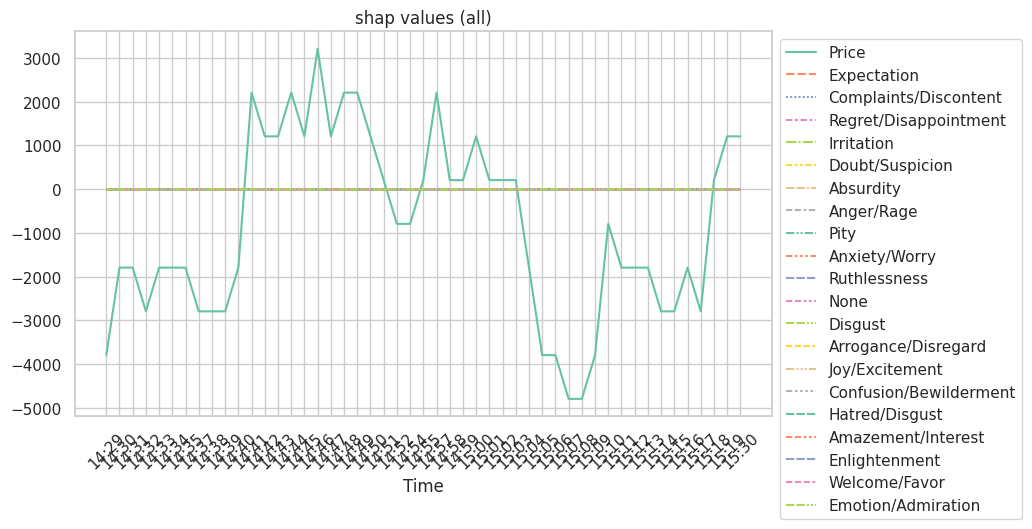

In [ ]:
sns.set(rc={'figure.figsize':(9,5)})
sns.set_style("whitegrid")

sns.lineplot(data=df_shapval_0r, palette='Set2')
plt.xticks(rotation=45)
plt.title('shap values (all)')
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.show()

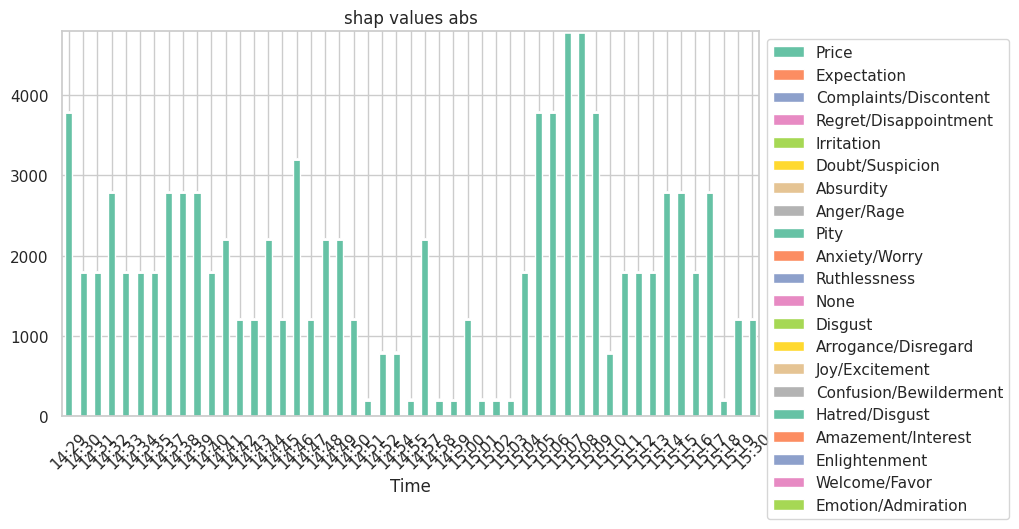

In [ ]:
sns.set(rc={'figure.figsize':(9,5)})
sns.set_style("whitegrid")

df_abs_shapval_0r = df_shapval_0r.abs()
colors = sns.color_palette('Set2',len(df_abs_shapval_0r))

df_abs_shapval_0r.plot(kind='bar', stacked=True, color=colors)
plt.xticks(rotation=45)
plt.title('shap values abs')
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.show()

In [ ]:
colnum = len(df_shapval_0r.columns)
abs_shapvals = []

for i in range(colnum) :
  abs_shapvals.append(df_shapval_0r.abs().iloc[:,i].values.sum())

In [ ]:
df_abs_shapvals = pd.DataFrame(abs_shapvals, columns=['sum of abs shap'], index=df_shapval_0r.columns)
df_abs_shapvals.sort_values(by='sum of abs shap', ascending=False, inplace=True)
df_abs_shapvals

,sum of abs shap
Price,91940.258158
Expectation,13.968099
Complaints/Discontent,13.617982
Anxiety/Worry,12.825871
Absurdity,12.304833
...,...
Arrogance/Disregard,5.961024
Amazement/Interest,5.455635
Welcome/Favor,5.204945
Enlightenment,5.115862


In [ ]:
shaps = df_abs_shapvals.iloc[1:,:]
shaps

,sum of abs shap
Expectation,13.968099
Complaints/Discontent,13.617982
Anxiety/Worry,12.825871
Absurdity,12.304833
Regret/Disappointment,12.079326
...,...
Arrogance/Disregard,5.961024
Amazement/Interest,5.455635
Welcome/Favor,5.204945
Enlightenment,5.115862


Text(0.5, 1.0, 'SHAP Summary')

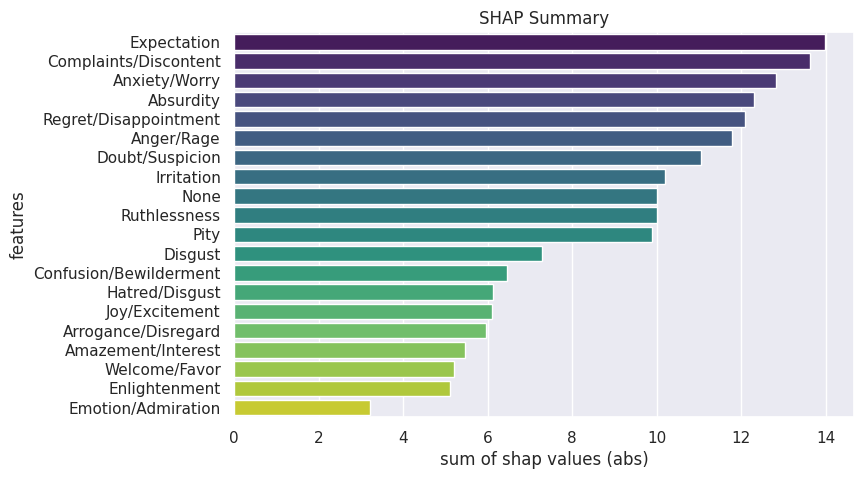

In [ ]:
sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(x=shaps['sum of abs shap'], y=shaps.index, palette='viridis')
plt.xlabel('sum of shap values (abs)')
plt.ylabel('features')
plt.title('SHAP Summary')